# Oridnary Kriging using scikit-gstat package

https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/skgstat/Variogram.py#L1312
    
    
https://github.com/mmaelicke/scikit-gstat/blob/22ff51ce798e0bfb4280392b32cbf9d9a480d89a/tutorials/01_getting_started.ipynb

https://scikit-gstat.readthedocs.io/en/latest/userguide/kriging.html#spatial-interpolation


In [31]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import skgstat as skg
from sklearn.model_selection import train_test_split, GridSearchCV
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
import matplotlib
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('font', size=20)

In [3]:
meuse_df = pd.read_csv("meuse_processed.csv")

In [4]:
display(meuse_df)

,x,y,cadmium,copper,lead,zinc,elev,dist,om,ffreq,soil,lime,landuse,dist.m
0,181072,333611,2.459589,4.442651,5.700444,6.929517,7.909,0.001358,13.6,1,1,1,Ah,50
1,181025,333558,2.151762,4.394449,5.624018,7.039660,6.983,0.012224,14.0,1,1,1,Ah,30
2,181165,333537,1.871802,4.219508,5.293305,6.461468,7.800,0.103029,13.0,1,1,1,Ah,150
3,181298,333484,0.955511,4.394449,4.753590,5.549076,7.655,0.190094,8.0,1,2,0,Ga,270
4,181307,333330,1.029619,3.871201,4.762174,5.594711,7.480,0.277090,8.7,1,2,0,Ah,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,179184,330182,-0.223144,2.995732,3.891820,5.111988,8.128,0.423837,4.7,3,1,0,Am,540
151,179085,330292,1.131402,3.663562,5.153292,6.206576,8.577,0.423837,9.1,3,1,0,Ah,520
152,178875,330311,0.741937,3.433987,4.779123,5.834811,8.429,0.277090,6.5,3,1,0,Ah,350
153,179466,330381,-0.223144,3.044522,3.931826,5.087596,9.406,0.358606,5.7,3,1,0,W,460


## Splitting Data

In [5]:
# Convert columns to numpy arrays
observed_location_columns_meuse = ['x', 'y']
observed_values_column_meuse = 'zinc'
observed_locations_meuse = meuse_df[observed_location_columns_meuse].values
observed_values_meuse = meuse_df[observed_values_column_meuse].values

In [6]:
X_train_meuse, X_test_meuse, y_train_meuse, y_test_meuse = train_test_split(observed_locations_meuse,
                                                                            observed_values_meuse, test_size=0.2, random_state=0)
print(f"X_train_meuse.shape: {X_train_meuse.shape}")
print(f"X_test_meuse.shape:  {X_test_meuse.shape}")
print(f"y_train_meuse.shape: {y_train_meuse.shape}")
print(f"y_test_meuse.shape:  {y_test_meuse.shape}")

X_train_meuse.shape: (124, 2)
X_test_meuse.shape:  (31, 2)
y_train_meuse.shape: (124,)
y_test_meuse.shape:  (31,)


## K-Fold Cross Validation

In [19]:
# Using list comprehension
x_data = [inner_list[0] for inner_list in X_train_meuse]
y_data = [inner_list[1] for inner_list in X_train_meuse]

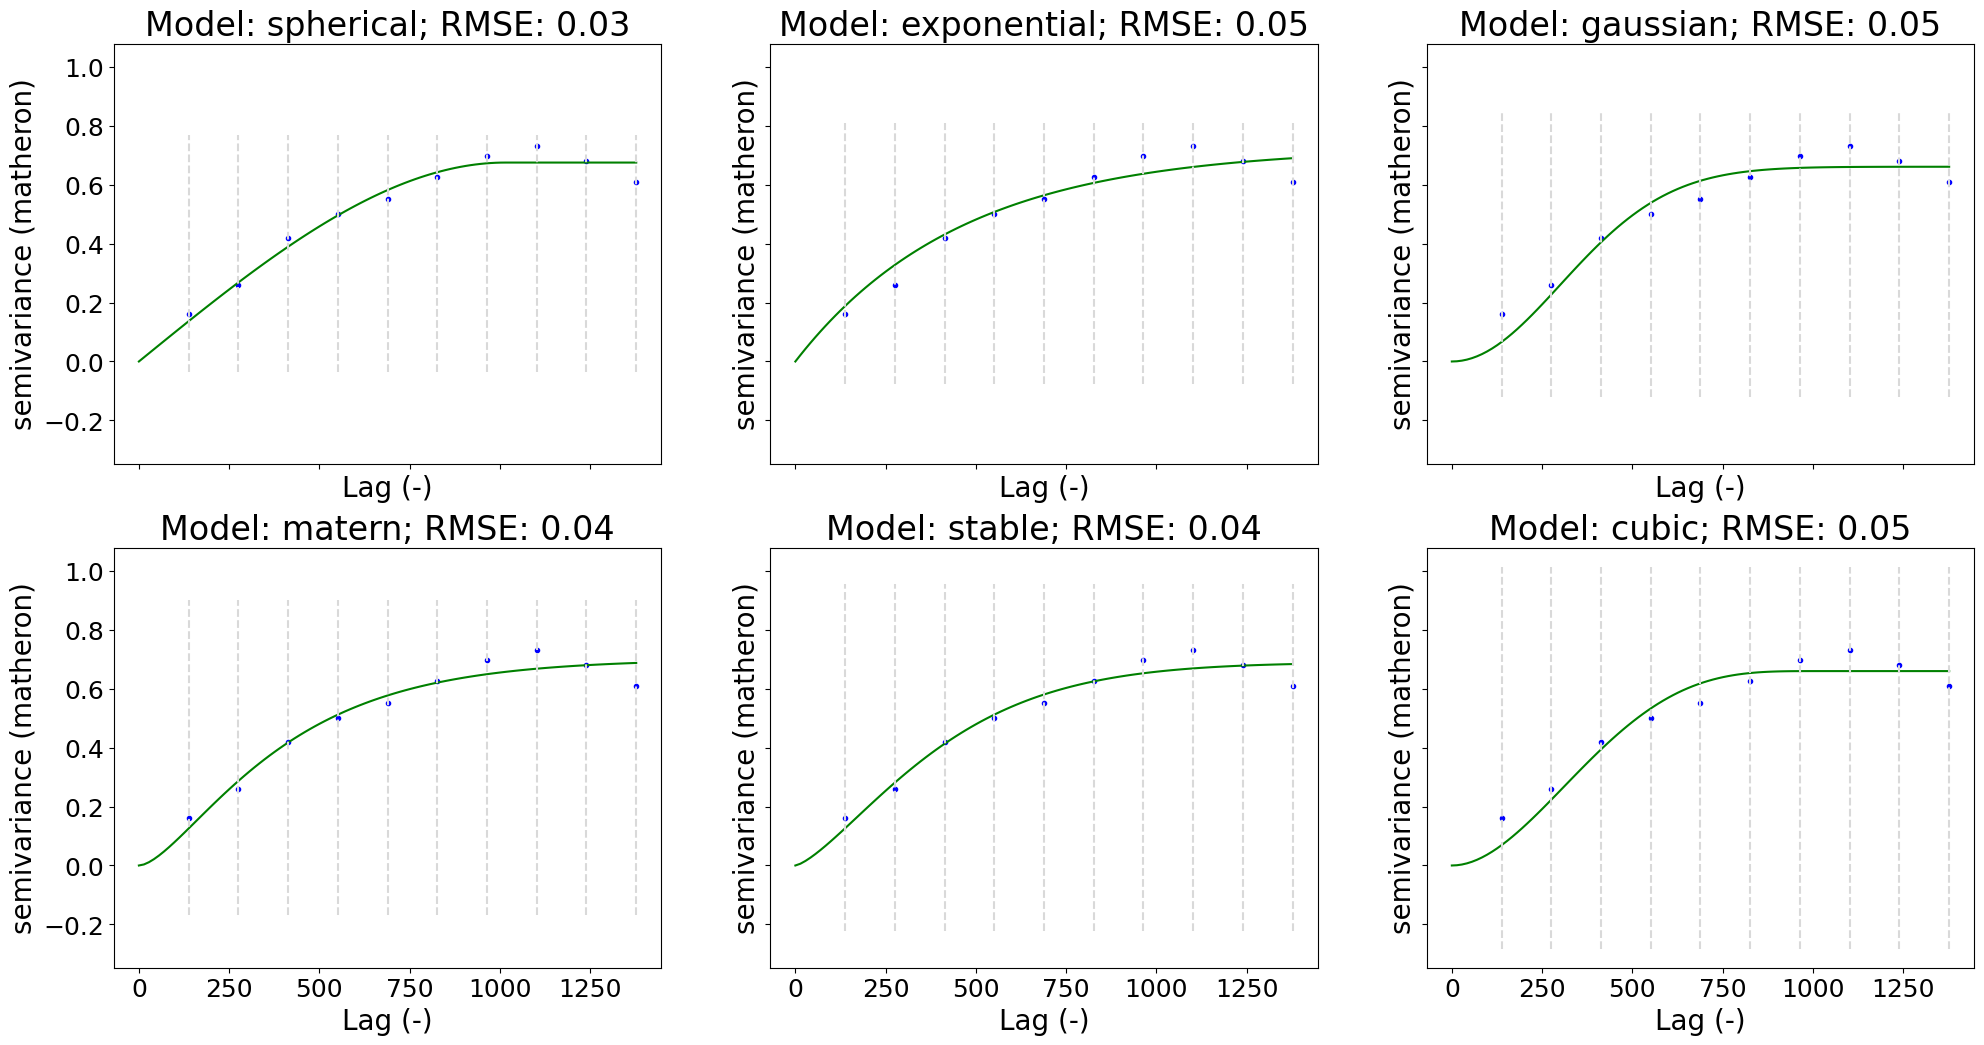

In [43]:
data = pd.DataFrame({
    'X': x_data,
    'Y': y_data,
    'Z': y_train_meuse
})

# Initialize an empty dictionary
cv_score_list = {}

#Instantiate the variogram with the train data
V = skg.Variogram(X_train_meuse, y_train_meuse,maxlag='median', normalize=False)
fig, _a = plt.subplots(2,3, figsize=(24, 12), sharex=True, sharey=True)
axes = _a.flatten()

#For each possible theoratical model, conduct K-Fold CV
for i, model in enumerate(('spherical', 'exponential', 'gaussian', 'matern', 'stable', 'cubic')):
    V.model = model
    V.plot(axes=axes[i], hist=False, show=False)
    axes[i].set_title('Model: %s; RMSE: %.2f' % (model, V.rmse))

    # Define K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize a list to store cross-validation results
    cv_scores_mae = []
    cv_scores_rmse = []
    cv_scores_mape = []

    # Perform K-Fold cross-validation
    for train_index, test_index in kfold.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Fit Ordinary Kriging model
        OK = skg.OrdinaryKriging(V, min_points=2, max_points=15, mode='exact')

        # Predict at test locations
        z_pred = OK.transform(test_data['X'], test_data['Y'])
        
        # Calculate RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mean_squared_error(test_data['Z'], z_pred))
        mae = mean_absolute_error(test_data['Z'], z_pred)
        mape = mean_absolute_percentage_error(test_data['Z'], z_pred)
        cv_scores_mae.append(mae)
        cv_scores_rmse.append(rmse)
        cv_scores_mape.append(mape)
        
        
    cv_score_list[model] = {
        'cv_scores_mae': cv_scores_mae,
        'cv_scores_rmse': cv_scores_rmse,
        'cv_scores_mape': cv_scores_mape
    }

In [44]:
cv = pd.DataFrame(cv_score_list)
display(cv)

,spherical,exponential,gaussian,matern,stable,cubic
cv_scores_mae,"[3.801403636316536e-15, 5.577760475716787e-15,...","[2.2026824808563106e-15, 3.623767952376511e-15...","[2.7133850721838826e-12, 2.0471802031352127e-1...","[5.4711790653527716e-15, 1.0835776720341527e-1...","[5.897504706808831e-15, 6.359357485052897e-15,...","[5.74473801862041e-14, 1.1375789199519205e-13,..."
cv_scores_rmse,"[4.8419981519170856e-15, 6.696182035515635e-15...","[2.6347629809804343e-15, 4.591117879940073e-15...","[5.795233262078774e-12, 3.5980845942612275e-12...","[7.254846628037419e-15, 1.494780795952368e-14,...","[7.828072247850565e-15, 1.0298274617522725e-14...","[7.834539224344886e-14, 1.8828393744762325e-13..."
cv_scores_mape,"[6.463912365815615e-16, 9.23414935641995e-16, ...","[3.7135122387856553e-16, 6.017329552366883e-16...","[4.1742495747136725e-13, 3.2751587977278664e-1...","[9.06670427322597e-16, 1.7809577131457344e-15,...","[9.954594254999007e-16, 1.067064659936926e-15,...","[9.403473164766107e-15, 1.779398413957242e-14,..."


Sample variance: 0.53   Variogram sill: 0.62
[nan nan]
Sample variance: 0.53   Variogram sill: 0.62
[nan nan]
Sample variance: 0.53   Variogram sill: 0.64
[nan nan]
Sample variance: 0.53   Variogram sill: 0.61
[nan nan]
Sample variance: 0.53   Variogram sill: 0.65
[nan nan]


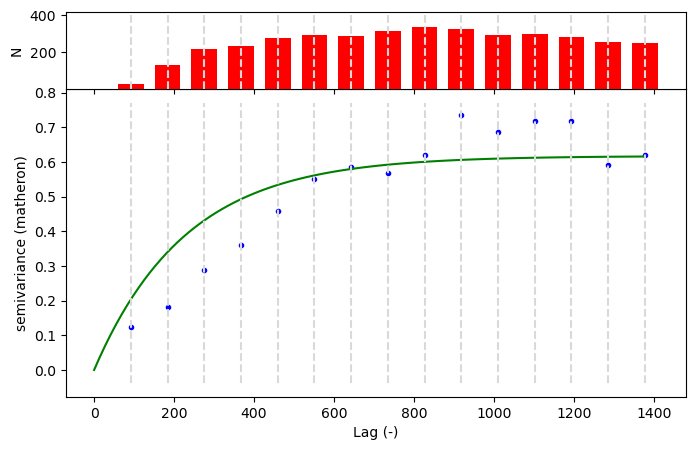

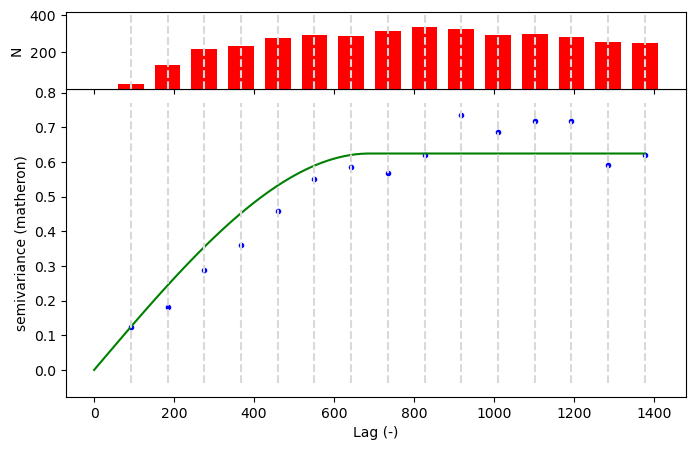

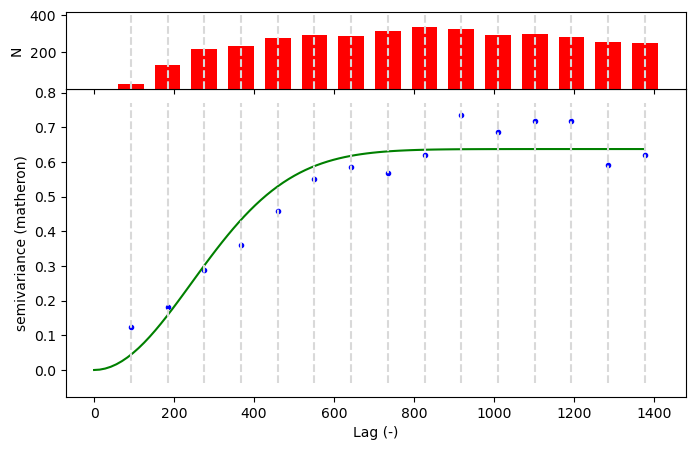

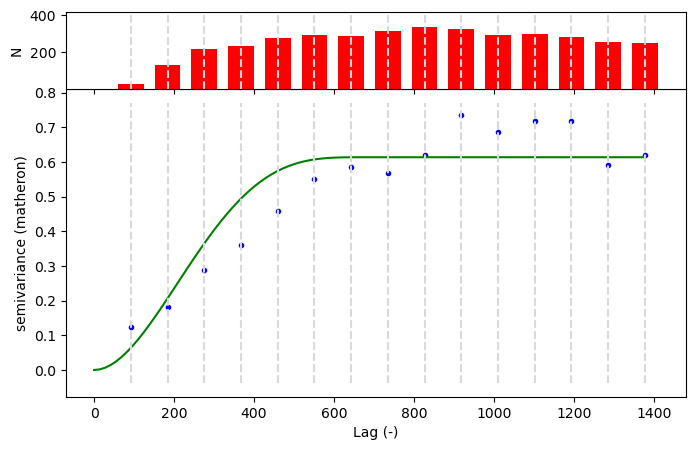

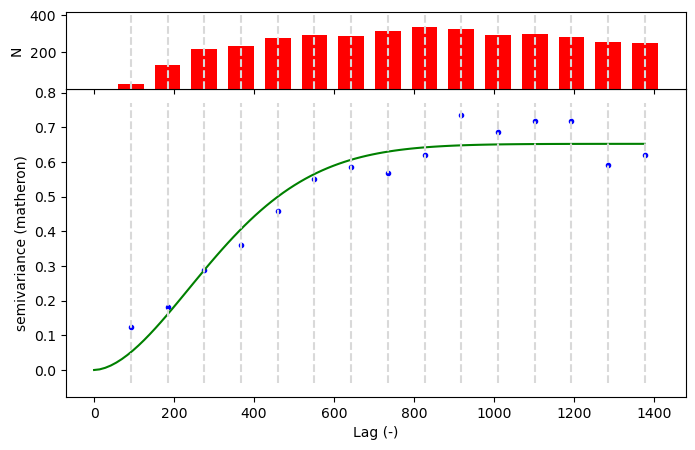

In [22]:
cv_results_df_list = []
models = ['exponential', 'spherical', 'gaussian', 'cubic', 'stable']
min_range = range(1,6)
max_range = range(6,15)
parameters = [
    {'min_points': min_range},
    {'max_points' : max_range}
]

for model in range(len(models)):
    V = skg.Variogram(X_train_meuse, y_train_meuse.flatten(), model = models[model],
                      fit_method = 'ml', maxlag='median', n_lags=15, normalize=False)
    fig = V.plot(show=False)
    print('Sample variance: %.2f   Variogram sill: %.2f' % (y_train_meuse.flatten().var(), V.describe()['sill']))
    ok = skg.OrdinaryKriging(V, mode='exact')
    pred_values = ok.transform(X_train_meuse[0],X_train_meuse[1])
    
    s2 = ok.sigma


Sample variance: 0.53   Variogram sill: 0.62
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


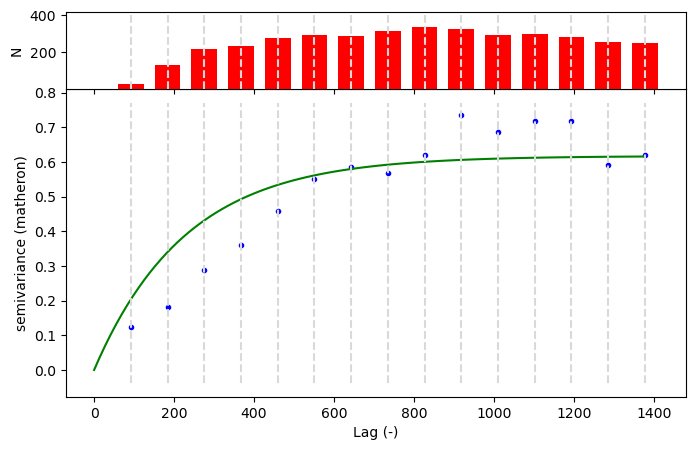

In [24]:
V = skg.Variogram(X_train_meuse, y_train_meuse.flatten(), model = 'exponential',
                  fit_method = 'ml', maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)
print('Sample variance: %.2f   Variogram sill: %.2f' % (y_train_meuse.flatten().var(), V.describe()['sill']))
ok = skg.OrdinaryKriging(V, mode='exact')

# build the target grid
x = X_train_meuse[0]
y = X_train_meuse[1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_train_meuse, field)
rmse = np.sqrt(mean_squared_error(y_train_meuse, field))
#print("MAPE:", round(test_score,3))
print("MAE:", round(mae,3))
print("RMSE:", round(rmse,3))

ValueError: Found input variables with inconsistent numbers of samples: [124, 100]

Sample variance: 0.53   Variogram sill: 0.62


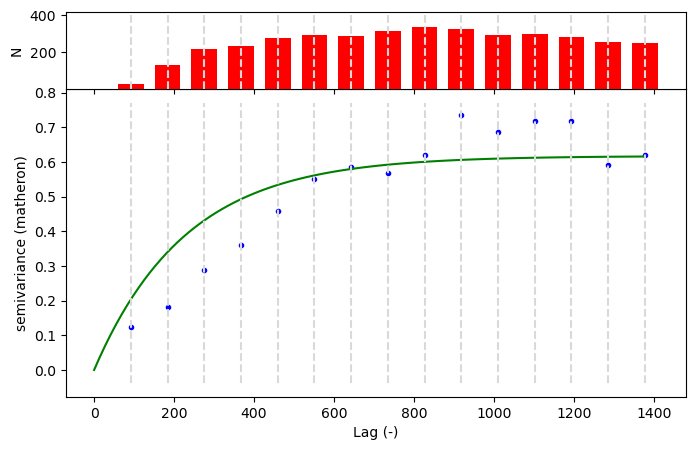

In [23]:
V = skg.Variogram(X_train_meuse, y_train_meuse.flatten(), model = 'exponential',
                  fit_method = 'ml', maxlag='median', n_lags=15, normalize=False)
fig = V.plot(show=False)
print('Sample variance: %.2f   Variogram sill: %.2f' % (y_train_meuse.flatten().var(), V.describe()['sill']))
ok = skg.OrdinaryKriging(V, mode='exact')
pred_values = ok.transform(X_train_meuse[0],X_train_meuse[1])
s2 = ok.sigma

In [20]:
X_train_meuse

array([[180555, 332707],
       [179301, 330179],
       [179462, 330766],
       [180704, 332664],
       [180237, 332351],
       [179782, 330540],
       [179547, 330245],
       [180973, 332687],
       [180114, 330803],
       [179076, 331005],
       [180292, 332157],
       [180625, 332847],
       [179526, 331936],
       [181133, 332570],
       [181118, 333214],
       [179604, 332059],
       [181165, 333537],
       [180107, 332101],
       [180410, 332031],
       [179618, 330458],
       [181191, 333115],
       [179470, 331125],
       [180862, 333116],
       [179030, 330082],
       [179550, 329940],
       [179489, 331633],
       [179110, 330758],
       [179337, 329870],
       [179414, 331494],
       [179085, 330433],
       [180201, 331160],
       [179991, 331069],
       [180265, 332297],
       [179717, 331441],
       [180135, 331552],
       [178701, 330557],
       [179334, 331366],
       [179293, 330797],
       [180173, 331923],
       [179140, 330955],


In [7]:
pprint(V.describe())

{'dist_func': 'euclidean',
 'effective_range': 948.7288337231124,
 'estimator': 'matheron',
 'kwargs': {},
 'model': 'spherical',
 'normalized_effective_range': 1302287.83139491,
 'normalized_nugget': 0,
 'normalized_sill': 284534179.8289792,
 'nugget': 0,
 'params': {'bin_func': 'even',
            'dist_func': 'euclidean',
            'estimator': 'matheron',
            'fit_method': 'ml',
            'fit_sigma': None,
            'maxlag': 1372.6660191029719,
            'model': 'spherical',
            'n_lags': 15,
            'normalize': False,
            'use_nugget': False,
            'verbose': False},
 'sill': 16066.250773906831}


In [8]:
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   948.73
Sill:              16066.25
Nugget:            0.00
        


In [9]:
ok = skg.OrdinaryKriging(V, min_points=5, max_points=15, mode='exact')

In [10]:
# build the target grid
x = coords[:,0]
y = coords[:,1]
# xx, yy = np.mgrid[0:99:100j, 0:99:100j]
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
s2 = ok.sigma.reshape(xx.shape)

In [11]:
print((xx.max() - xx.min()) / 100)
print((yy.max() - yy.min()) / 100)

27.85
38.97


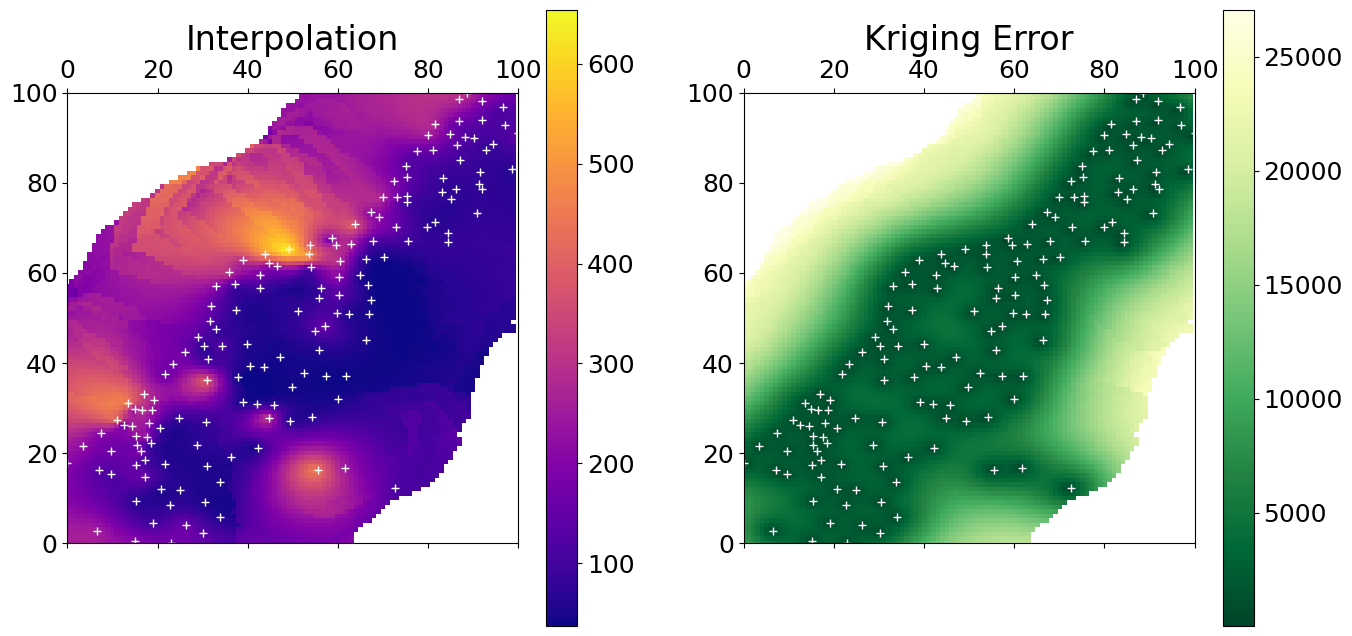

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# rescale the coordinates to fit the interpolation raster
x_ = (x - x.min()) / (x.max() - x.min()) * 100
y_ = (y - y.min()) / (y.max() - y.min()) * 100

art = axes[0].matshow(field.T, origin='lower', cmap='plasma', vmin=vals.min(), vmax=vals.max())
axes[0].set_title('Interpolation')
axes[0].plot(x_, y_, '+w')
axes[0].set_xlim((0,100))
axes[0].set_ylim((0,100))
plt.colorbar(art, ax=axes[0])
art = axes[1].matshow(s2.T, origin='lower', cmap='YlGn_r')
axes[1].set_title('Kriging Error')
plt.colorbar(art, ax=axes[1])
axes[1].plot(x_, y_, '+w')
axes[1].set_xlim((0,100))
axes[1].set_ylim((0,100));